In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [53]:
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin

yfin.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2010-01-01', end='2024-01-01')

df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409360,447610800
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700


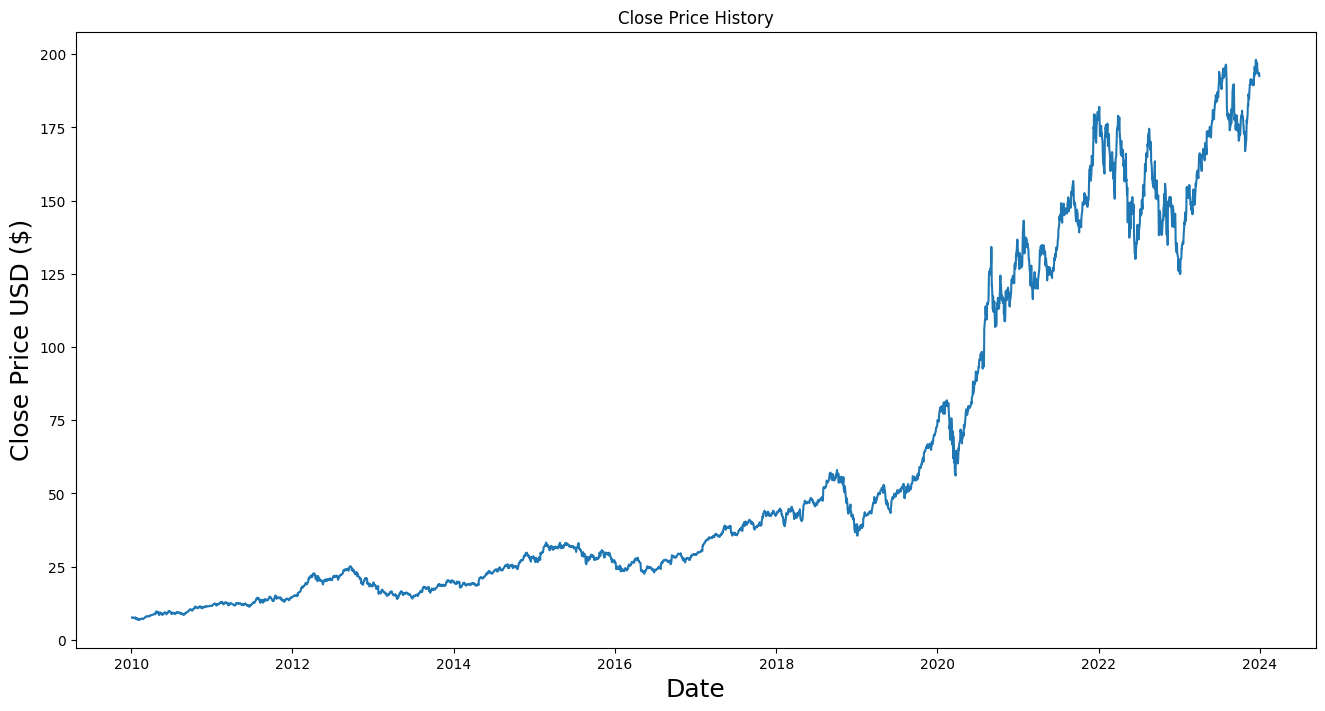

In [54]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [55]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

2818

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00410081],
       [0.00416991],
       [0.00353313],
       ...,
       [0.97406547],
       [0.97631386],
       [0.97082368]])

In [57]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([4.10081399e-03, 4.16990948e-03, 3.53312539e-03, 3.46029250e-03,
       3.72172994e-03, 3.37253003e-03, 2.92621544e-03, 3.47336463e-03,
       3.24554370e-03, 2.59195259e-03, 4.29315593e-03, 3.67504878e-03,
       2.99157355e-03, 1.06441674e-03, 2.05787553e-03, 2.59382004e-03,
       2.95609707e-03, 1.35199593e-03, 1.86495266e-06, 5.00460545e-04,
       7.11476946e-04, 1.34079126e-03, 0.00000000e+00, 6.36779110e-04,
       3.86548837e-04, 7.73102661e-04, 5.73288442e-04, 1.23621678e-03,
       1.55554505e-03, 2.11950124e-03, 1.96077333e-03, 2.03173129e-03,
       1.79643809e-03, 1.56301234e-03, 9.35565469e-04, 1.60783353e-03,
       1.85806380e-03, 2.34732217e-03, 3.16338107e-03, 3.13723683e-03,
       3.22686675e-03, 3.48456930e-03, 5.02331232e-03, 5.04758912e-03,
       5.78334535e-03, 6.12321054e-03, 6.24645698e-03, 6.45187603e-03,
       5.93647342e-03, 6.05038264e-03, 5.98875942e-03, 6.08773156e-03,
       5.63955451e-03, 6.10640602e-03, 6.78053654e-03, 6.96914608e-03,
     

In [58]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [59]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2758, 60, 1)

In [60]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
2758/2758 [==============================] - 105s 37ms/step - loss: 4.7775e-04
Epoch 2/2
2758/2758 [==============================] - 100s 36ms/step - loss: 2.3373e-04


In [63]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test =  dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [64]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [65]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 2s 24ms/step


In [66]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 20.128392700712457
R-squared: 0.9453063268305502
Mean Absolute Error: 3.6619721109216865
Root Mean Squared Error: 4.486467730934042


<ipython-input-67-858541529963>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


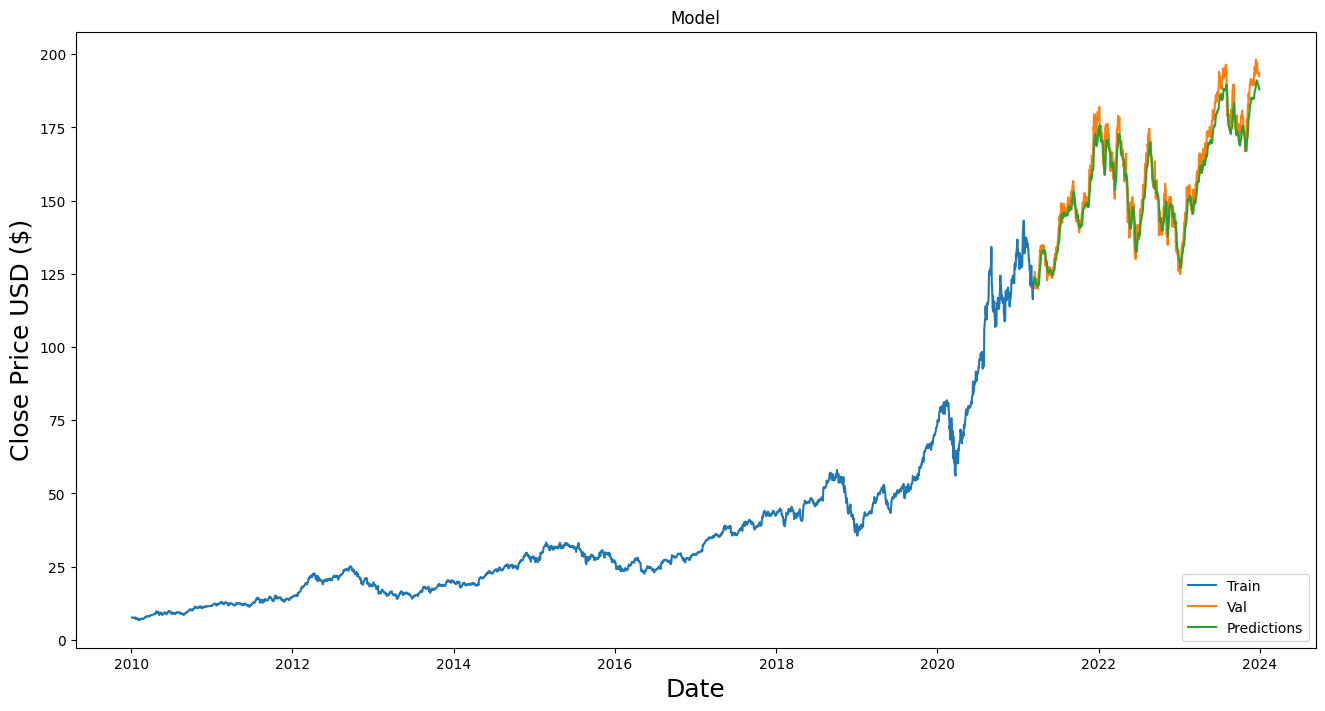

In [67]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()